In [1]:
import json
import math
import numpy as np
from stereo_camera import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [2]:
total_frames = 238
dist_threshold = 0.30
max_depth = 13000

In [3]:
hflip = False
image_dir = './calibrate_images'

if (hflip):
    image_dir = image_dir + '_hflip'

calibration_data = np.load(image_dir + '/calibration_data.npz')
left_camera_matrix = calibration_data['left_camera_matrix']
left_map_1 = calibration_data['left_map_1']
left_map_2 = calibration_data['left_map_2']
right_map_1 = calibration_data['right_map_1']
right_map_2 = calibration_data['right_map_2']
Q = calibration_data['Q']
T = calibration_data['T']

fx = left_camera_matrix[0,0]
fy = left_camera_matrix[1,1]
cx = left_camera_matrix[0,2]
cy = left_camera_matrix[1,2]

b = abs(T[0][0])

In [4]:
config_json_filename = image_dir + '/sbm_config.json'

with open(config_json_filename) as sbm_config_file:
    sbm_config = json.load(sbm_config_file)

sbm = create_SBM(sbm_config)

sift = cv2.xfeatures2d.SIFT_create()

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [5]:
frame_dir = './odometry_data/frames/'

def get_frame(i):
    zeroes = "0" * (5 - len(str(i)))
    image_filename = "{0}/frame_{1}{2}.png".format(frame_dir, zeroes, str(i))
    return cv2.imread(image_filename, cv2.IMREAD_COLOR)

def create_depth_map(disparity):
    disparity[disparity <= 0] = 0.1
    depth_map = np.ones(disparity.shape, np.single)
    depth_map[:] = fx * b / disparity[:]
    return depth_map

def generate_pnp_coords(matches, kp1, kp2, depth_map, dist_threshold, max_depth):
    ix = 0
    world_coords = np.zeros((len(matches), 3), np.float32)
    image_coords = np.zeros((len(matches), 2), np.float32)
    
    for (m,n) in matches:
        if m.distance < dist_threshold*n.distance:
            p1u, p1v = kp1[m.queryIdx].pt
            p2u, p2v = kp2[m.trainIdx].pt
            Z = depth_map[int(p1v),int(p1u)]

            if (Z < max_depth):
                world_coords[ix,2] = Z
                world_coords[ix,0] = Z / fx * (p1u - cx)
                world_coords[ix,1] = Z / fy * (p1v - cy)        

                image_coords[ix,0] = p2u
                image_coords[ix,1] = p2v

                ix+= 1

    return world_coords[:ix], image_coords[:ix]

In [6]:
trajectory = np.zeros((3, total_frames))
P = np.eye(4)

current_frame = get_frame(1)
_, disparity, current_image, _ = compute_3dImage(sbm, current_frame, left_map_1, left_map_2, right_map_1, right_map_2, Q, hflip)
current_depth_map = create_depth_map(disparity)
current_kp, current_des = sift.detectAndCompute(current_image, None)

for frameIx in range(2,total_frames):
    next_frame = get_frame(frameIx)
    _, disparity, next_image, _ = compute_3dImage(sbm, next_frame, left_map_1, left_map_2, right_map_1, right_map_2, Q, hflip)
    next_depth_map = create_depth_map(disparity)
    next_kp, next_des = sift.detectAndCompute(next_image, None)

    matches = flann.knnMatch(current_des, next_des, k=2)

    world_coords, image_coords = generate_pnp_coords(matches, current_kp, next_kp, current_depth_map, dist_threshold, max_depth)

    retval, rvec, tvec, inliers = cv2.solvePnPRansac(world_coords, image_coords,left_camera_matrix, None, flags=cv2.SOLVEPNP_EPNP) 
    R, _ = cv2.Rodrigues(rvec)   
    t = tvec.T.flatten()
    
    P_new = np.eye(4)
    P_new[0:3,0:3] = R.T
    P_new[0:3,3] = (-R.T).dot(t)
    P = P.dot(P_new)

    trajectory[:,frameIx] = P[:3,3]
    
    current_depth_map = next_depth_map
    current_kp, current_des = next_kp, next_des

In [7]:
def visualize_trajectory(trajectory):
    # Unpack X Y Z each trajectory point
    locX = []
    locY = []
    locZ = []
    # This values are required for keeping equal scale on each plot.
    # matplotlib equal axis may be somewhat confusing in some situations because of its various scale on
    # different axis on multiple plots
    max = -math.inf
    min = math.inf

    # Needed for better visualisation
    maxY = -math.inf
    minY = math.inf

    for i in range(0, trajectory.shape[1]):
        current_pos = trajectory[:, i]
        
        locX.append(current_pos.item(0))
        locY.append(current_pos.item(1))
        locZ.append(current_pos.item(2))
        if np.amax(current_pos) > max:
            max = np.amax(current_pos)
        if np.amin(current_pos) < min:
            min = np.amin(current_pos)

        if current_pos.item(1) > maxY:
            maxY = current_pos.item(1)
        if current_pos.item(1) < minY:
            minY = current_pos.item(1)

    auxY_line = locY[0] + locY[-1]
    if max > 0 and min > 0:
        minY = auxY_line - (max - min) / 2
        maxY = auxY_line + (max - min) / 2
    elif max < 0 and min < 0:
        minY = auxY_line + (min - max) / 2
        maxY = auxY_line - (min - max) / 2
    else:
        minY = auxY_line - (max - min) / 2
        maxY = auxY_line + (max - min) / 2

    # Set styles
    mpl.rc("figure", facecolor="white")
    plt.style.use("seaborn-whitegrid")

    # Plot the figure
    fig = plt.figure(figsize=(8, 6), dpi=100)
    gspec = gridspec.GridSpec(3, 3)
    ZY_plt = plt.subplot(gspec[0, 1:])
    YX_plt = plt.subplot(gspec[1:, 0])
    traj_main_plt = plt.subplot(gspec[1:, 1:])
    D3_plt = plt.subplot(gspec[0, 0], projection='3d')

    # Actual trajectory plotting ZX
    toffset = 1.06
    traj_main_plt.set_title("Autonomous vehicle trajectory (Z, X)", y=toffset)
    traj_main_plt.set_title("Trajectory (Z, X)", y=1)
    traj_main_plt.plot(locZ, locX, ".-", label="Trajectory", zorder=1, linewidth=1, markersize=4)
    traj_main_plt.set_xlabel("Z")
    # traj_main_plt.axes.yaxis.set_ticklabels([])
    # Plot reference lines
    traj_main_plt.plot([locZ[0], locZ[-1]], [locX[0], locX[-1]], "--", label="Auxiliary line", zorder=0, linewidth=1)
    # Plot camera initial location
    traj_main_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    traj_main_plt.set_xlim([min, max])
    traj_main_plt.set_ylim([min, max])
    traj_main_plt.legend(loc=1, title="Legend", borderaxespad=0., fontsize="medium", frameon=True)

    # Plot ZY
    # ZY_plt.set_title("Z Y", y=toffset)
    ZY_plt.set_ylabel("Y", labelpad=-4)
    ZY_plt.axes.xaxis.set_ticklabels([])
    ZY_plt.plot(locZ, locY, ".-", linewidth=1, markersize=4, zorder=0)
    ZY_plt.plot([locZ[0], locZ[-1]], [(locY[0] + locY[-1]) / 2, (locY[0] + locY[-1]) / 2], "--", linewidth=1, zorder=1)
    ZY_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    ZY_plt.set_xlim([min, max])
    ZY_plt.set_ylim([minY, maxY])

    # Plot YX
    # YX_plt.set_title("Y X", y=toffset)
    YX_plt.set_ylabel("X")
    YX_plt.set_xlabel("Y")
    YX_plt.plot(locY, locX, ".-", linewidth=1, markersize=4, zorder=0)
    YX_plt.plot([(locY[0] + locY[-1]) / 2, (locY[0] + locY[-1]) / 2], [locX[0], locX[-1]], "--", linewidth=1, zorder=1)
    YX_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    YX_plt.set_xlim([minY, maxY])
    YX_plt.set_ylim([min, max])

    # Plot 3D
    D3_plt.set_title("3D trajectory", y=toffset)
    D3_plt.plot3D(locX, locZ, locY, zorder=0)
    D3_plt.scatter(0, 0, 0, s=8, c="red", zorder=1)
    D3_plt.set_xlim3d(min, max)
    D3_plt.set_ylim3d(min, max)
    D3_plt.set_zlim3d(min, max)
    D3_plt.tick_params(direction='out', pad=-2)
    D3_plt.set_xlabel("X", labelpad=0)
    D3_plt.set_ylabel("Z", labelpad=0)
    D3_plt.set_zlabel("Y", labelpad=-2)
    
    # plt.axis('equal')
    D3_plt.view_init(45, azim=30)
    plt.tight_layout()
    plt.show()

In [8]:
trajectory[0,0]-trajectory[0,total_frames-1]

-945.8757454327719

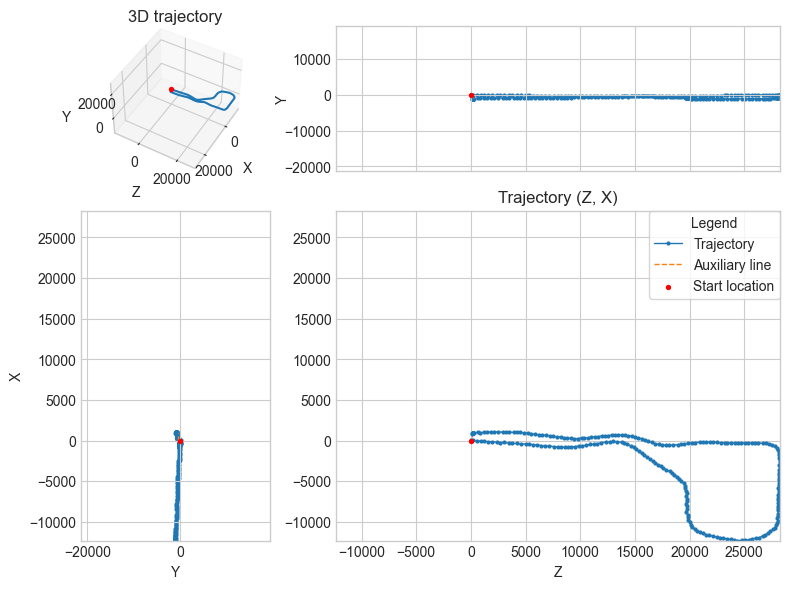

In [9]:
visualize_trajectory(trajectory)

In [10]:
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[     0.              0.             47.05625696     49.55662619
     -58.93839398    -52.36007428    -68.88287264   -138.41544537
    -131.27562597   -193.93307442   -250.85564845   -232.56062928
    -297.53280561   -342.95439857   -355.21913168   -418.38713607
    -401.86985583   -402.30923945   -512.70863265   -540.9383649
    -616.13819071   -675.3465646    -659.99051138   -742.05153817
    -795.47685192   -800.69792468   -839.00742075   -790.01603728
    -751.24870924   -753.09680066   -648.05071414   -608.86831294
    -597.70973731   -472.71264992   -443.14624402   -384.11716955
    -252.72276594   -182.14844503   -132.31019987    -97.469494
    -165.3018714    -206.58549386   -300.28768314   -456.14316574
    -637.85381542   -823.56857417  -1068.63023393  -1265.47192315
   -1570.64879284  -1819.56656713  -2041.89530305  -2319.60679967
   -2531.23289337  -2695.31242767  -2980.54281931  -3176.50018697
   -3372.25811314  -3613.51902779  -3798.99114713  -3977.5385646